# Syrtis Demonstration - Conduction through Shells
# Heat Gain into a Cryogen Tank at Boca Chica, TX

To demonstrate the StaticShell feature of Syrtis, we can analyse a simple system. SpaceX have made use of large double-walled steel tanks to store huge volumes of cryogenic propellants at their Boca Chica facility. These have an inner wall diameter of around 9m (to allow common tooling with the Starship/Super Heavy vehicle) and an outer wall diameter of around 12m. The gap between them is believed to be filled with expanded perlite.

The choice to use perlite rather than a simple air gap, as well as the dimensions of this gap, can be crudely analysed with Syrtis. It should be noted that this is not an intended use for the solver, as it uses the enormously dense terrestrial atmosphere, but serves as an interesting demonstration.

In [19]:
from syrtis.configuration import Configuration
from syrtis.solver import Solver
from syrtis.material import Solid, ConstrainedIdealGas
from syrtis.habitat import Habitat
import numpy as np

## Setting up the Simulation

Before we can begin simulating, we need to define some parameters. Firstly, the materials used (stainless steel with a low-emissivity coating, and ambient air) need to be defined. The simulation Configuration - specifying the conditions of the environment around the object, need to be declared.

The steel and perlite are both defined as simple Solid materials, while the air is a ConstrainedIdealGas with an appropriately high pressure and molecular mass appropriate for air.

The Configuration is set with an air and ground temperature of 30C, a steady 11mph (5m/s) wind and the sun directly overhead. The internal tank temperature is set at a constant 60K (-213C), well below the boiling point of oxygen as is appropriate for a subchilled system. Due to the default Configuration using a carbon dioxide atmosphere, the already-defined `ambient_air` is set as the atmosphere for the Configuration.

In [26]:
# Materials definitions
# The absorbivity of perlite and air are assumed as 0.5 but are not required
painted_steel = Solid("Painted steel", 15, 8700, 500, 0.1)
perlite = Solid("Expanded perlite aggregate", 0.1, 216, 837, 0.5)
ambient_air = ConstrainedIdealGas("Air at sea level (15C, 1atm)", 101325, 29, 0.71, 17.9e-6, 1.01e3, 0.0252)
unmoving_air = Solid("Air without natural convection", 0.0252, 1.2, 1010, 0.5)

boca_chica = Configuration("Boca Chica at noon", "constant temperature",
300, 1, 0.29, 300, 101325, 1, "cross", 90, 90, 1000, T_habitat=60)
boca_chica.air = ambient_air

# Simulation iteration

With these parameters set, we can create the main simulation iteration loop. It will iterate over a range of spacings between the inner and outer tanks, comparing the total heat gain into each. Both perlite and ambient air will be used as gap-filling materials.

`np.logspace` is used to create a range of spacings, between 3.1mm and 3.1m. 

Each physical tank (a Habitat in Syrtis terminology) is composed of an inner layer of ambient air - the thermal properties are not important - an inner layer of 5mm steel, a gap of varying thickness and an outer layer of 5mm steel. The geometry for each tank is then verified with the `verify_geometry()` function to ensure that the layers do not overlap and that all Habitat variables like area have been set.

Both the `Habitat` and `Configuration` are used as inputs for a `Solver` object which contains the iterator.

A constant-temperature (on the internal wall) solution is then found by iteration. The heat flux into the tank, which must be counteracted by the chillers, is saved for plotting.

In [37]:
heat_gain_air = []
heat_gain_perlite = []
heat_gain_static_air = []
thicknesses = np.logspace(-2.5, 0.5, 80)

for thickness in thicknesses:
    # Arrangement with an air layer
    tankfarm_air = Habitat("vertical", 50, "flat")
    tankfarm_air.create_static_shell(ambient_air, 4.5)
    tankfarm_air.create_static_shell(painted_steel, 5e-3)
    tankfarm_air.create_static_shell(ambient_air, thickness)
    tankfarm_air.create_static_shell(painted_steel, 5e-3)

    tankfarm_air.verify_geometry()

    solver_air = Solver("Tank farm heat gain, {:.2f}m air layer".format(thickness), tankfarm_air, boca_chica)
    q_gain_air = solver_air.iterate_constant_temperature()

    heat_gain_air.append(-q_gain_air/1e6)


    # Arrangement with an expanded perlite layer
    tankfarm_perlite = Habitat("vertical", 50, "flat")
    tankfarm_perlite.create_static_shell(ambient_air, 4.5)
    tankfarm_perlite.create_static_shell(painted_steel, 5e-3)
    tankfarm_perlite.create_static_shell(perlite, thickness)
    tankfarm_perlite.create_static_shell(painted_steel, 5e-3)

    tankfarm_perlite.verify_geometry()

    solver_perlite = Solver("Tank farm heat gain, {:.2f}m perlite layer".format(thickness), tankfarm_perlite, boca_chica)
    q_gain_perlite = solver_perlite.iterate_constant_temperature()

    heat_gain_perlite.append(-q_gain_perlite/1e6)

    # Arrangement with a static, non-convecting air layer
    tankfarm_static_air = Habitat("vertical", 50, "flat")
    tankfarm_static_air.create_static_shell(ambient_air, 4.5)
    tankfarm_static_air.create_static_shell(painted_steel, 5e-3)
    tankfarm_static_air.create_static_shell(unmoving_air, thickness)
    tankfarm_static_air.create_static_shell(painted_steel, 5e-3)

    tankfarm_static_air.verify_geometry()

    solver_static_air = Solver("Tank farm heat gain, {:.2f}m static air layer".format(thickness), tankfarm_static_air, boca_chica)
    q_gain_static_air = solver_static_air.iterate_constant_temperature()

    heat_gain_static_air.append(-q_gain_static_air/1e6)

The heat gains can then be plotted for both perlite and air-filled gaps. For illustrative purposes, a set of simulations have also been run with "non-convecting air".

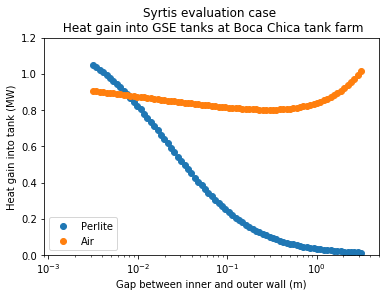

## Results
The behaviour for perlite is roughly as expected - a monotonic decrease as diameter increases. For very thin gaps the heat gain is higher for perlite due to the greater static thermal conductivity of the material. It is obvious that a thicker insulation layer is always better. As such, the approximately 1.5m thick layer that SpaceX ultimately chose (for a 12m external diameter) is likely due to tooling and transport limitations rather than a desire to minimise heat flux. With 1.5m of perlite insulation the heat flux is just 23kW, a few percent of the uninsulated loss.

The behaviour for air seems rather odd, as it does not behave in a similar fashion. This is due to the natural convection model that Syrtis uses to determine the thermal resistance of gas-filled insulation layers. The difference between a conduction-only and conduction plus natural convection model is shown below. "Non-convecting air" describes a hypothetical material with the thermal conductivity of air but without the ability to flow in convection currents. This is approximately the property of aerogel.

The decrease and then increase for convecting air is due to the formation of larger and larger convection cells - and thus more effective heat transfer - as the gap width increases. It would in theory be possible to choose a gap width that minimises heat flux, but this would be highly dependent on the temperature and pressure properties of the gas. As such it might be unwise to choose this!

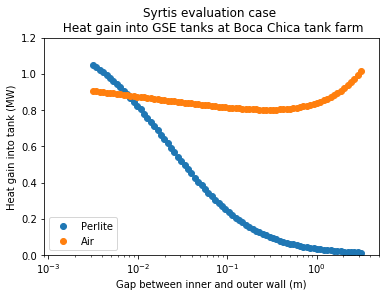

In [41]:
import matplotlib.pyplot as plt

plt.scatter(thicknesses, heat_gain_perlite, label="Perlite")
plt.scatter(thicknesses, heat_gain_air, label="Air")

plt.xscale("log")
plt.xlim(9e-4, 5)
plt.ylim(0, 1.2)

plt.xlabel("Gap between inner and outer wall (m)")
plt.ylabel("Heat gain into tank (MW)")
plt.title("Syrtis evaluation case \n Heat gain into GSE tanks at Boca Chica tank farm")

plt.legend()
plt.show()

In [40]:
# Check heat flux with a 1.5m thickness - approximately what SpaceX use
print(thicknesses[-9])
print(heat_gain_perlite[-9] * 1e6)

1.5710953080792556
23348.480447419137


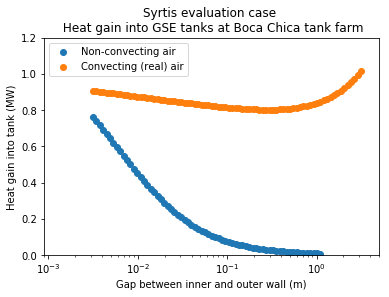

In [42]:
plt.scatter(thicknesses, heat_gain_static_air, label="Non-convecting air")
plt.scatter(thicknesses, heat_gain_air, label="Convecting (real) air")


plt.xscale("log")
plt.xlim(9e-4, 5)
plt.ylim(0, 1.2)

plt.xlabel("Gap between inner and outer wall (m)")
plt.ylabel("Heat gain into tank (MW)")
plt.title("Syrtis evaluation case \n Heat gain into GSE tanks at Boca Chica tank farm")

plt.legend()
plt.show()